# Minimal example in numpyro

## Debug

## Setup

### Import libraries

In [1]:
import platform
from inspect import getmembers
from pprint import pprint
from types import FunctionType

import arviz as az
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [2]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

In [3]:
print(platform.python_version())
print(numpyro.__version__)
print(jax.__version__)
print(az.__version__)

3.10.9
0.11.0
0.4.4
0.14.0


### Setup plotting

In [4]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

# import matplotlib_inline

In [5]:
fonts_path = "/usr/share/texmf/fonts/opentype/public/lm/" #ubuntu
# fonts_path = "~/Library/Fonts/" # macos
# fonts_path = "/usr/share/fonts/OTF/"  # arch
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmsans10-regular.otf")
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmroman10-regular.otf")

In [6]:
# https://stackoverflow.com/a/36622238/446907
%config InlineBackend.figure_formats = ['svg']

In [7]:
plt.style.use("default")  # reset default parameters
# https://stackoverflow.com/a/3900167/446907
plt.rcParams.update(
    {
        "font.size": 16,
        "font.family": ["sans-serif"],
        "font.serif": ["Latin Modern Roman"] + plt.rcParams["font.serif"],
        "font.sans-serif": ["Latin Modern Sans"] + plt.rcParams["font.sans-serif"],
    }
)

### Utility functions

In [8]:
def attributes(obj):
    disallowed_names = {
        name for name, value in getmembers(type(obj)) if isinstance(value, FunctionType)
    }
    return {
        name: getattr(obj, name)
        for name in dir(obj)
        if name[0] != "_" and name not in disallowed_names and hasattr(obj, name)
    }


def print_attributes(obj):
    pprint(attributes(obj))

## Execute

### Define sample data

In [9]:
N_obs = 100

In [10]:
observations = np.random.randn(N_obs)

### Define model

In [11]:
def model(obs=None):
    mu = numpyro.sample("mu", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
    with numpyro.plate("N_obs", N_obs):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=obs)

In [12]:
# numpyro.render_model(
#     model, model_args=(observations,), render_distributions=True, render_params=True
# )

### Fit model

In [13]:
R = 1000

In [14]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

In [15]:
kernel = NUTS(model)
mcmc = MCMC(
    kernel, num_warmup=500, num_samples=R, num_chains=4, chain_method="parallel"
)

In [16]:
mcmc.run(rng_key_, observations)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [17]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.12      0.09      0.12     -0.03      0.26   3379.02      1.00
     sigma      0.89      0.06      0.88      0.78      0.99   2911.75      1.00

Number of divergences: 0


In [18]:
posterior_samples = mcmc.get_samples(group_by_chain=False)

In [19]:
rng_key, rng_key_ = jax.random.split(rng_key)
posterior_predictive = Predictive(model, posterior_samples)
posterior_predictions = posterior_predictive(rng_key_)

In [20]:
[v.shape for k, v in posterior_predictions.items()]

[(4000, 100)]

In [21]:
rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(model, num_samples=500)
prior_predictions = prior_predictive(rng_key_)

In [22]:
[v.shape for k, v in prior_predictions.items()]

[(500,), (500, 100), (500,)]

### Organize output data

In [23]:
type(mcmc)

numpyro.infer.mcmc.MCMC

In [24]:
data = az.from_numpyro(
    mcmc,
    prior=prior_predictions,
    posterior_predictive=posterior_predictions,
)

In [25]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### Evaluate model

#### Plot autocorrelation to evaluate MCMC chain mixing

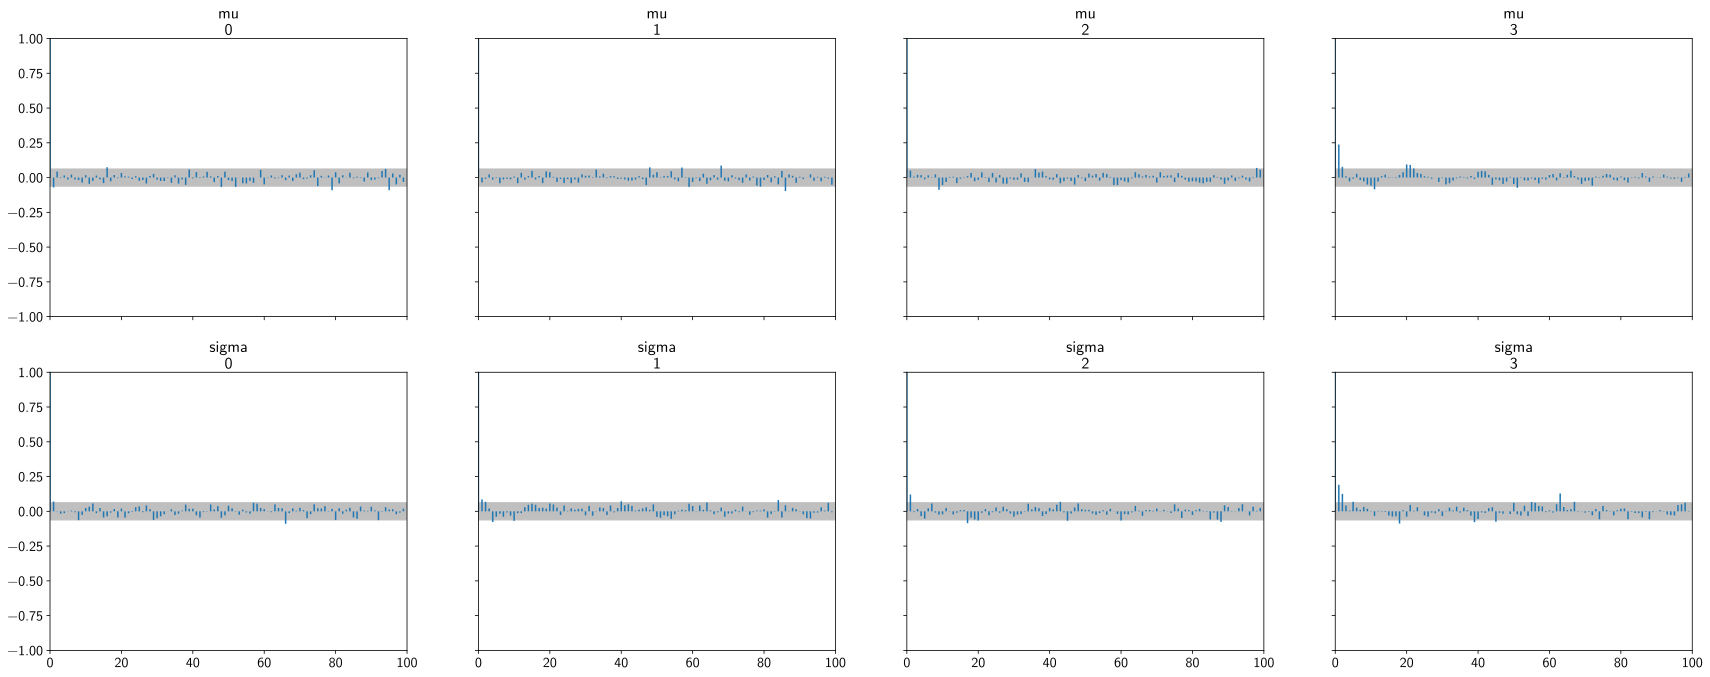

In [26]:
# with model:
az.plot_autocorr(data, var_names=["mu", "sigma"]);

#### Plot prior and posterior predictive distributions

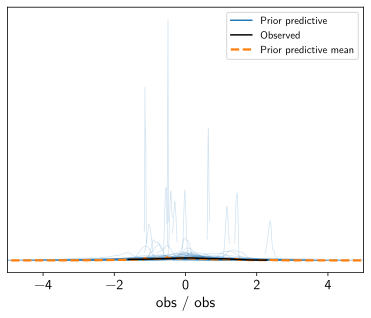

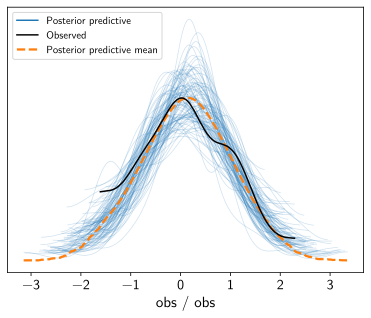

In [27]:
ax_pr_pred = az.plot_ppc(
    data,
    group="prior",
    data_pairs={"obs": "obs"},
    num_pp_samples=100,
    random_seed=7,
)
ax_pr_pred.set_xlim([-5, 5])
az.plot_ppc(
    data,
    group="posterior",
    data_pairs={"obs": "obs"},
    num_pp_samples=100,
    random_seed=7,
);

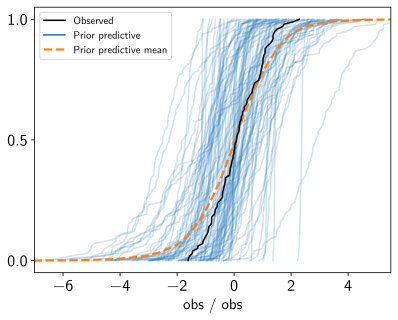

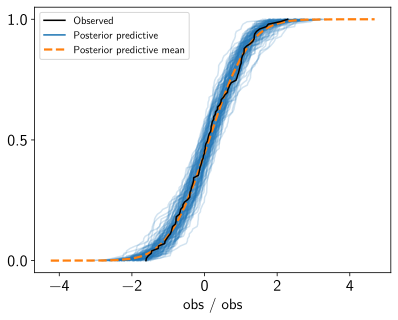

In [28]:
ax_pr_pred_cum = az.plot_ppc(
    data,
    group="prior",
    data_pairs={"obs": "obs"},
    kind="cumulative",
    num_pp_samples=100,
    random_seed=7,
)
ax_pr_pred_cum.set_xlim([-7, 5.5])
az.plot_ppc(
    data,
    group="posterior",
    data_pairs={"obs": "obs"},
    kind="cumulative",
    num_pp_samples=100,
    random_seed=7,
);

#### Characterize posterior distribution

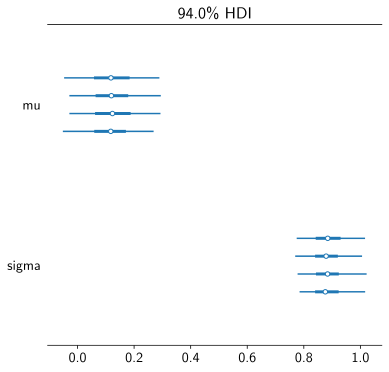

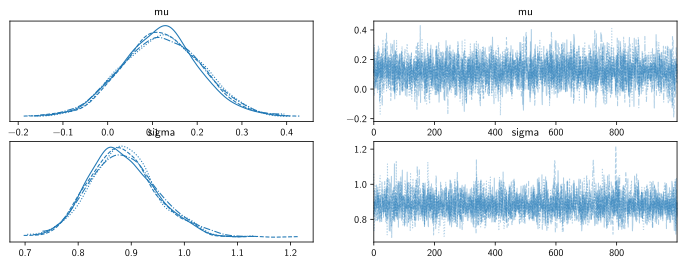

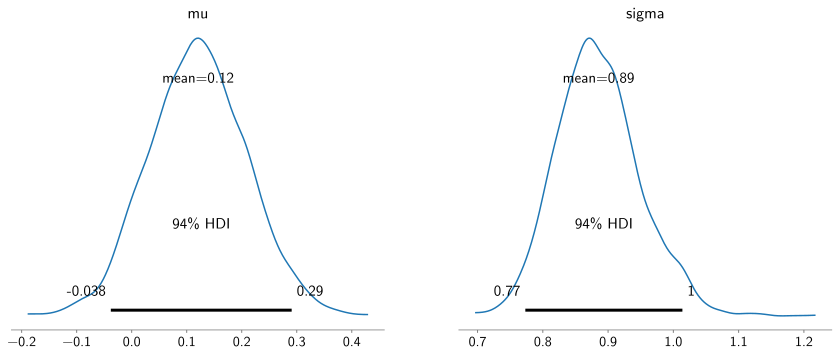

In [29]:
az.plot_forest(data);
az.plot_trace(data);
az.plot_posterior(data);